In [1]:
from models.network_swinir import *
import os
from collections import OrderedDict
from datetime import datetime
import json
import re
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

In [2]:
def prepare_oom_mr_image(path):
    """
    Read an MR image, convert to RGB, resize to 500×500, 
    and generate a noisy low-quality version.
    Returns (imgname, img_lq, img_gt)
    """
    # --- get name ---
    imgname, _ = os.path.splitext(os.path.basename(path))

    # --- read image ---
    img_gt = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img_gt = cv2.cvtColor(img_gt, cv2.COLOR_GRAY2RGB)

    # --- resize to 500×500 ---
    img_gt = cv2.resize(img_gt, (256, 256), interpolation=cv2.INTER_AREA)

    # --- normalize to [0, 1] ---
    img_gt = img_gt.astype(np.float32) / 255.0

    # --- generate noisy version (LQ) ---
    np.random.seed(0)
    noise = np.random.normal(0, 50 / 255., img_gt.shape)
    img_lq = np.clip(img_gt + noise, 0, 1)

    return imgname, img_lq, img_gt

def get_image_pair(path):
    (imgname, imgext) = os.path.splitext(os.path.basename(path))
    img_gt = cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float32) / 255.
    np.random.seed(seed=0)
    img_lq = img_gt + np.random.normal(0, 50 / 255., img_gt.shape)

    return imgname, img_lq, img_gt

def show_three_images(img_lq, img_gt, output):
    # resize to 256×256
    img_lq = TF.resize(img_lq, [64, 64])
    img_gt = TF.resize(img_gt, [64, 64])
    output = TF.resize(output, [64, 64])

    # remove batch dimension and convert to numpy
    imgs = [img_lq[0], img_gt[0], output[0]]
    imgs = [img.permute(1, 2, 0).detach().cpu().numpy() for img in imgs]

    # plot in a row
    titles = ['LQ', 'GT', 'Output']
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
import cv2
import numpy as np
import torch


def calculate_psnr(img1, img2, crop_border, input_order='HWC', test_y_channel=False):
    """Calculate PSNR (Peak Signal-to-Noise Ratio).

    Ref: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

    Args:
        img1 (ndarray): Images with range [0, 255].
        img2 (ndarray): Images with range [0, 255].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the PSNR calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.

    Returns:
        float: psnr result.
    """

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = reorder_image(img1, input_order=input_order)
    img2 = reorder_image(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = to_y_channel(img1)
        img2 = to_y_channel(img2)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20. * np.log10(255. / np.sqrt(mse))


def _ssim(img1, img2):
    """Calculate SSIM (structural similarity) for one channel images.

    It is called by func:`calculate_ssim`.

    Args:
        img1 (ndarray): Images with range [0, 255] with order 'HWC'.
        img2 (ndarray): Images with range [0, 255] with order 'HWC'.

    Returns:
        float: ssim result.
    """

    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2, crop_border, input_order='HWC', test_y_channel=False):
    """Calculate SSIM (structural similarity).

    Ref:
    Image quality assessment: From error visibility to structural similarity

    The results are the same as that of the official released MATLAB code in
    https://ece.uwaterloo.ca/~z70wang/research/ssim/.

    For three-channel images, SSIM is calculated for each channel and then
    averaged.

    Args:
        img1 (ndarray): Images with range [0, 255].
        img2 (ndarray): Images with range [0, 255].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the SSIM calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.

    Returns:
        float: ssim result.
    """

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = reorder_image(img1, input_order=input_order)
    img2 = reorder_image(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = to_y_channel(img1)
        img2 = to_y_channel(img2)

    ssims = []
    for i in range(img1.shape[2]):
        ssims.append(_ssim(img1[..., i], img2[..., i]))
    return np.array(ssims).mean()


def _blocking_effect_factor(im):
    block_size = 8

    block_horizontal_positions = torch.arange(7, im.shape[3] - 1, 8)
    block_vertical_positions = torch.arange(7, im.shape[2] - 1, 8)

    horizontal_block_difference = (
                (im[:, :, :, block_horizontal_positions] - im[:, :, :, block_horizontal_positions + 1]) ** 2).sum(
        3).sum(2).sum(1)
    vertical_block_difference = (
                (im[:, :, block_vertical_positions, :] - im[:, :, block_vertical_positions + 1, :]) ** 2).sum(3).sum(
        2).sum(1)

    nonblock_horizontal_positions = np.setdiff1d(torch.arange(0, im.shape[3] - 1), block_horizontal_positions)
    nonblock_vertical_positions = np.setdiff1d(torch.arange(0, im.shape[2] - 1), block_vertical_positions)

    horizontal_nonblock_difference = (
                (im[:, :, :, nonblock_horizontal_positions] - im[:, :, :, nonblock_horizontal_positions + 1]) ** 2).sum(
        3).sum(2).sum(1)
    vertical_nonblock_difference = (
                (im[:, :, nonblock_vertical_positions, :] - im[:, :, nonblock_vertical_positions + 1, :]) ** 2).sum(
        3).sum(2).sum(1)

    n_boundary_horiz = im.shape[2] * (im.shape[3] // block_size - 1)
    n_boundary_vert = im.shape[3] * (im.shape[2] // block_size - 1)
    boundary_difference = (horizontal_block_difference + vertical_block_difference) / (
                n_boundary_horiz + n_boundary_vert)

    n_nonboundary_horiz = im.shape[2] * (im.shape[3] - 1) - n_boundary_horiz
    n_nonboundary_vert = im.shape[3] * (im.shape[2] - 1) - n_boundary_vert
    nonboundary_difference = (horizontal_nonblock_difference + vertical_nonblock_difference) / (
                n_nonboundary_horiz + n_nonboundary_vert)

    scaler = np.log2(block_size) / np.log2(min([im.shape[2], im.shape[3]]))
    bef = scaler * (boundary_difference - nonboundary_difference)

    bef[boundary_difference <= nonboundary_difference] = 0
    return bef


def calculate_psnrb(img1, img2, crop_border, input_order='HWC', test_y_channel=False):
    """Calculate PSNR-B (Peak Signal-to-Noise Ratio).

    Ref: Quality assessment of deblocked images, for JPEG image deblocking evaluation
    # https://gitlab.com/Queuecumber/quantization-guided-ac/-/blob/master/metrics/psnrb.py

    Args:
        img1 (ndarray): Images with range [0, 255].
        img2 (ndarray): Images with range [0, 255].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the PSNR calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.

    Returns:
        float: psnr result.
    """

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = reorder_image(img1, input_order=input_order)
    img2 = reorder_image(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = to_y_channel(img1)
        img2 = to_y_channel(img2)

    # follow https://gitlab.com/Queuecumber/quantization-guided-ac/-/blob/master/metrics/psnrb.py
    img1 = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0) / 255.
    img2 = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0) / 255.

    total = 0
    for c in range(img1.shape[1]):
        mse = torch.nn.functional.mse_loss(img1[:, c:c + 1, :, :], img2[:, c:c + 1, :, :], reduction='none')
        bef = _blocking_effect_factor(img1[:, c:c + 1, :, :])

        mse = mse.view(mse.shape[0], -1).mean(1)
        total += 10 * torch.log10(1 / (mse + bef))

    return float(total) / img1.shape[1]


def reorder_image(img, input_order='HWC'):
    """Reorder images to 'HWC' order.

    If the input_order is (h, w), return (h, w, 1);
    If the input_order is (c, h, w), return (h, w, c);
    If the input_order is (h, w, c), return as it is.

    Args:
        img (ndarray): Input image.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            If the input image shape is (h, w), input_order will not have
            effects. Default: 'HWC'.

    Returns:
        ndarray: reordered image.
    """

    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' "'HWC' and 'CHW'")
    if len(img.shape) == 2:
        img = img[..., None]
    if input_order == 'CHW':
        img = img.transpose(1, 2, 0)
    return img


def to_y_channel(img):
    """Change to Y channel of YCbCr.

    Args:
        img (ndarray): Images with range [0, 255].

    Returns:
        (ndarray): Images with range [0, 255] (float type) without round.
    """
    img = img.astype(np.float32) / 255.
    if img.ndim == 3 and img.shape[2] == 3:
        img = bgr2ycbcr(img, y_only=True)
        img = img[..., None]
    return img * 255.


def _convert_input_type_range(img):
    """Convert the type and range of the input image.

    It converts the input image to np.float32 type and range of [0, 1].
    It is mainly used for pre-processing the input image in colorspace
    convertion functions such as rgb2ycbcr and ycbcr2rgb.

    Args:
        img (ndarray): The input image. It accepts:
            1. np.uint8 type with range [0, 255];
            2. np.float32 type with range [0, 1].

    Returns:
        (ndarray): The converted image with type of np.float32 and range of
            [0, 1].
    """
    img_type = img.dtype
    img = img.astype(np.float32)
    if img_type == np.float32:
        pass
    elif img_type == np.uint8:
        img /= 255.
    else:
        raise TypeError('The img type should be np.float32 or np.uint8, ' f'but got {img_type}')
    return img


def _convert_output_type_range(img, dst_type):
    """Convert the type and range of the image according to dst_type.

    It converts the image to desired type and range. If `dst_type` is np.uint8,
    images will be converted to np.uint8 type with range [0, 255]. If
    `dst_type` is np.float32, it converts the image to np.float32 type with
    range [0, 1].
    It is mainly used for post-processing images in colorspace convertion
    functions such as rgb2ycbcr and ycbcr2rgb.

    Args:
        img (ndarray): The image to be converted with np.float32 type and
            range [0, 255].
        dst_type (np.uint8 | np.float32): If dst_type is np.uint8, it
            converts the image to np.uint8 type with range [0, 255]. If
            dst_type is np.float32, it converts the image to np.float32 type
            with range [0, 1].

    Returns:
        (ndarray): The converted image with desired type and range.
    """
    if dst_type not in (np.uint8, np.float32):
        raise TypeError('The dst_type should be np.float32 or np.uint8, ' f'but got {dst_type}')
    if dst_type == np.uint8:
        img = img.round()
    else:
        img /= 255.
    return img.astype(dst_type)


def bgr2ycbcr(img, y_only=False):
    """Convert a BGR image to YCbCr image.

    The bgr version of rgb2ycbcr.
    It implements the ITU-R BT.601 conversion for standard-definition
    television. See more details in
    https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion.

    It differs from a similar function in cv2.cvtColor: `BGR <-> YCrCb`.
    In OpenCV, it implements a JPEG conversion. See more details in
    https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion.

    Args:
        img (ndarray): The input image. It accepts:
            1. np.uint8 type with range [0, 255];
            2. np.float32 type with range [0, 1].
        y_only (bool): Whether to only return Y channel. Default: False.

    Returns:
        ndarray: The converted YCbCr image. The output image has the same type
            and range as input image.
    """
    img_type = img.dtype
    img = _convert_input_type_range(img)
    if y_only:
        out_img = np.dot(img, [24.966, 128.553, 65.481]) + 16.0
    else:
        out_img = np.matmul(
            img, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786], [65.481, -37.797, 112.0]]) + [16, 128, 128]
    out_img = _convert_output_type_range(out_img, img_type)
    return out_img


In [3]:
ckpt_path = "/home/data1/musong/workspace/python/SwinIR/model_zoo/swinir/005_colorDN_DFWB_s128w8_SwinIR-M_noise50.pth"
folder_gt = "/home/data1/musong/workspace/python/SwinIR/testsets/McMaster"
mr_img_path = '/home/data1/musong/data/fastmri/diffusion_images/file_brain_AXT2_208_2080298_3.jpg'
border = 0
window_size = 8
device = 'cuda:1'

In [4]:
model = SwinIR(upscale=1, in_chans=3, img_size=128, window_size=8,
            img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
            mlp_ratio=2, upsampler='', resi_connection='1conv')

pretrained_model = torch.load(ckpt_path)
param_key_g = 'params'
model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
model = model.to(device)

unn = SwinIR(upscale=1, in_chans=3, img_size=128, window_size=8,
            img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
            mlp_ratio=2, upsampler='', resi_connection='1conv')

unn = unn.to(device)

/home/data1/musong/envs/main/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
data = get_image_pair(f'{folder_gt}/1.tif')
img_lq = data[1]
img_gt = data[2]

_, img_lq, img_gt = prepare_oom_mr_image(mr_img_path)

img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1)) 
img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(device) 
img_gt = np.transpose(img_gt if img_gt.shape[2] == 1 else img_gt[:, :, [2, 1, 0]], (2, 0, 1)) 
img_gt = torch.from_numpy(img_gt).float().unsqueeze(0)

with torch.no_grad():
    output = model(img_lq)


with torch.no_grad():
    unn_output = unn(img_lq)

# # free up GPU tensors explicitly
# del img_lq, output
# torch.cuda.empty_cache()

/home/data1/musong/envs/main/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62203765..1.4819162].


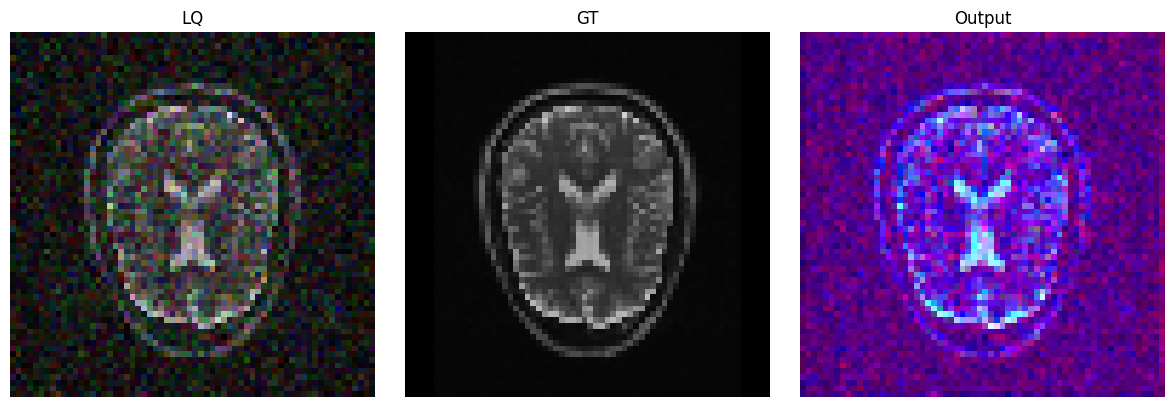

In [6]:
show_three_images(img_lq, img_gt, unn_output)

In [7]:
img_gt = (img_gt * 255.0).round().detach().cpu().numpy().astype(np.uint8) 
img_lq = (img_lq * 255.0).round().detach().cpu().numpy().astype(np.uint8) 
output = (output * 255.0).round().detach().cpu().numpy().astype(np.uint8) 
unn_output = (unn_output * 255.0).round().detach().cpu().numpy().astype(np.uint8) 
print(calculate_psnr(img_lq, img_gt, crop_border=0))
print(calculate_psnr(output, img_gt, crop_border=0))
print(calculate_psnr(unn_output, img_gt, crop_border=0))

16.336218985089058
24.192496566480678
6.3488209526640755
